<center>
    
## Aprendizaje No Supervisado DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2019 dataset
 
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [2]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [3]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [4]:
df=pd.read_csv("players_21.csv")

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [5]:
n=10000
df_n=df.loc[:n] #los primeros n
df_n=df_n[(df_n['overall']>70)] # mejores jugadores

skills_ratings = ['pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

print(len(skills_ratings), 'variables numéricas: skills/habilidades')

df_skills=df_n[skills_ratings]

46 variables numéricas: skills/habilidades


# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


In [6]:
df_skills.fillna(0,inplace=True)

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

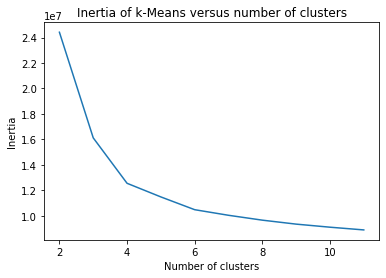

In [7]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [8]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_skills) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  12560494.1605865


In [9]:
len(clusters)

4512

**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

**Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [10]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[15]
skill_2=skills_ratings[26]

In [11]:
df.head()

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     200389  https://sofifa.com/player/200389/jan-oblak/210002   
3     188545  https://sofifa.com/player/188545/robert-lewand...   
4     190871  https://sofifa.com/player/190871/neymar-da-sil...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   33  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   35  1985-02-05   
2           J. Oblak                            Jan Oblak   27  1993-01-07   
3     R. Lewandowski                   Robert Lewandowski   31  1988-08-21   
4          Neymar Jr        Neymar da Silva Santos Júnior   28  1992-02-05   

   height_cm  weight_kg nationality            club_name  \
0        170         72   Argentina         FC Barcelona   
1        187         83    Portugal             Juventus   
2        188         87    Slovenia      Atlético Madrid   
3        184         80      Poland    FC Bayern München   
4        175         68      Brazil  Paris Saint-Germain   

              league_name  league_rank  overall  potential  value_eur  \
0  Spain Primera Division          1.0       93         93   67500000   
1         Italian Serie A          1.0       92         92   46000000   
2  Spain Primera Division          1.0       91         93   75000000   
3    German 1. Bundesliga          1.0       91         91   80000000   
4          French Ligue 1          1.0       91         91   90000000   

   wage_eur player_positions preferred_foot  international_reputation  \
0    560000       RW, ST, CF           Left                         5   
1    220000           ST, LW          Right                         5   
2    125000               GK          Right                         3   
3    240000               ST          Right                         4   
4    270000          LW, CAM          Right                         5   

   weak_foot  skill_moves      work_rate             body_type real_face  \
0          4            4     Medium/Low                 Messi       Yes   
1          4            5       High/Low            C. Ronaldo       Yes   
2          3            1  Medium/Medium  PLAYER_BODY_TYPE_259       Yes   
3          4            4    High/Medium  PLAYER_BODY_TYPE_276       Yes   
4          5            5    High/Medium                Neymar       Yes   

   release_clause_eur                                        player_tags  \
0         138400000.0  #Dribbler, #Distance Shooter, #FK Specialist, ...   
1          75900000.0  #Aerial Threat, #Dribbler, #Distance Shooter, ...   
2         159400000.0                                                NaN   
3         132000000.0              #Distance Shooter, #Clinical Finisher   
4         166500000.0  #Speedster, #Dribbler, #Playmaker, #FK Special...   

  team_position  team_jersey_number loaned_from      joined  \
0           CAM                10.0         NaN  2004-07-01   
1            LS                 7.0         NaN  2018-07-10   
2            GK                13.0         NaN  2014-07-16   
3            ST                 9.0         NaN  2014-07-01   
4            LW                10.0         NaN  2017-08-03   

   contract_valid_until nation_position  nation_jersey_number  pace  shooting  \
0                2021.0              RW                  10.0  85.0      92.0   
1                2022.0              LS                   7.0  89.0      93.0   
2                2023.0              GK                   1.0   NaN       NaN   
3                2023.0             NaN                   NaN  78.0      91.0   
4                2022.0             NaN                   NaN  91.0      85.0   

   passing  dribbling  defending  physic  gk_diving  gk_handling  gk_kicking  \
0     91.0       95.0       38.0

In [12]:
df_skills["cluster"] = clusters

In [13]:
mediocampistas = ["CAM","CM","RM","LM", "LCM", "RCM"]
delanteros = ["LW","RW","CF","ST", "LAM", "LF", "RF", "LS", "RS", "RAM", "SUB"]
defensores = ["LWB", "LB", "CB", "RB", "RWB", "LCB", "RCB","RDM","LDM","CDM", "RES"]

In [14]:
df_skill_copy = df_skills.copy()

In [15]:
df.columns

Index(['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob',
       'height_cm', 'weight_kg', 'nationality', 'club_name',
       ...
       'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'],
      dtype='object', length=106)

In [16]:
def positions(row):
    if row["team_position"] in mediocampistas:
        return "mediocampista"
    elif row["team_position"] in delanteros:
        return "delanteros"
    elif row["team_position"] in defensores:
        return "defensores"
    else:
        return "arquero"
df_skill_copy["position"] = df.apply(positions, axis=1)

In [17]:
df_skill_copy

pace  shooting  passing  dribbling  defending  physic  gk_diving  \
0     85.0      92.0     91.0       95.0       38.0    65.0        0.0   
1     89.0      93.0     81.0       89.0       35.0    77.0        0.0   
2      0.0       0.0      0.0        0.0        0.0     0.0       87.0   
3     78.0      91.0     78.0       85.0       43.0    82.0        0.0   
4     91.0      85.0     86.0       94.0       36.0    59.0        0.0   
...    ...       ...      ...        ...        ...     ...        ...   
4507  86.0      54.0     69.0       71.0       57.0    52.0        0.0   
4508  82.0      68.0     64.0       73.0       32.0    58.0        0.0   
4509  76.0      61.0     71.0       75.0       62.0    83.0        0.0   
4510   0.0       0.0      0.0        0.0        0.0     0.0       71.0   
4511  67.0      68.0     70.0       73.0       61.0    75.0        0.0   

      gk_handling  gk_kicking  gk_reflexes  gk_speed  gk_positioning  \
0             0.0         0.0          0.0       0.0             0.0   
1             0.0         0.0          0.0       0.0             0.0   
2            92.0        78.0         90.0      52.0            90.0   
3             0.0         0.0          0.0       0.0             0.0   
4             0.0         0.0          0.0       0.0             0.0   
...           ...         ...          ...       ...             ...   
4507          0.0         0.0          0.0       0.0             0.0   
4508          0.0         0.0          0.0       0.0             0.0   
4509          0.0         0.0          0.0       0.0             0.0   
4510         72.0        71.0         67.0      21.0            71.0   
4511          0.0         0.0          0.0       0.0             0.0   

      attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                     85                   95                          70   
1                     84                   95                          90   
2                     13                   11                          15   
3                     71                   94                          85   
4                     85                   87                          62   
...                  ...                  ...                         ...   
4507                  76                   54                          54   
4508                  68                   68                          48   
4509                  67                   55                          51   
4510                  14                    6                          13   
4511                  59                   70                          50   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                          91                 88               96   
1                          82                 86               88   
2                          43                 13               12   
3                          84                 89               85   
4                          87                 87               95   
...                       ...                ...              ...   
4507                       67                 55               70   
4508                       69                 61               73   
4509                       73                 51               73   
4510                       21                  9                9   
4511                       75                 61               73   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0              93                 94                  91                  96   
1              81                 76                  77                  92   
2              13                 14                  40                  30   
3              79                 85                  70                  88   
4              88                 89                  81                  95   
...           ... 

In [ ]:
sns.pairplot(
    df_skills[:1000],
    x_vars=skills_ratings[0:46:6],
    y_vars=skills_ratings[0:46:6],
    hue="cluster"
)

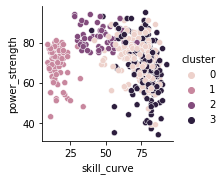

In [18]:
sns.pairplot(
    df_skills[:500],
    x_vars="skill_curve",
    y_vars="power_strength",
    hue="cluster"
)

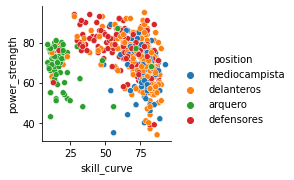

In [19]:
sns.pairplot(
    df_skill_copy[:500],
    x_vars="skill_curve",
    y_vars="power_strength",
    hue="position"
)

Comparamos lo realizado por kmeans y lo agrupado manualmente
Se ve que a los arqueros los agrupa de manera correcta, existe una interconexión entre las demás posiciones.

**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?


# Cantidad de observaciones

In [20]:
df_skill_copy["position"].value_counts()

delanteros       1972
defensores       1412
mediocampista     746
arquero           382
Name: position, dtype: int64

In [21]:
df_skills["cluster"].value_counts()

0    1660
3    1478
2     930
1     444
Name: cluster, dtype: int64

La distribucion generada a partir de los clusters es muy similar a lo forzado por nosotros anteriormente

# Análisis descriptivo

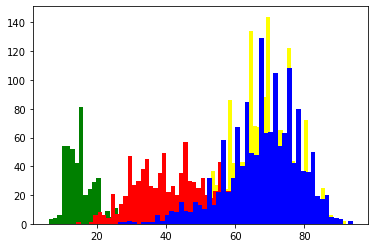

In [22]:
df_0 = df_skills[ df_skills['cluster']==0]
df_1 = df_skills[ df_skills['cluster']==1]
df_2 = df_skills[ df_skills['cluster']==2]
df_3 = df_skills[ df_skills['cluster']==3]

plt.hist(df_0['skill_curve'], color='yellow', bins=50)
plt.hist(df_1['skill_curve'], color='green', bins=50)
plt.hist(df_2['skill_curve'], color='red', bins=50)
plt.hist(df_3['skill_curve'], color='blue', bins=50)
plt.show()

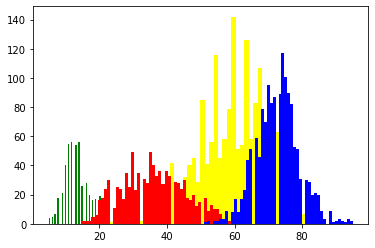

In [23]:
# delanteros
df_0 = df_skills[ df_skills['cluster']==0]
df_1 = df_skills[ df_skills['cluster']==1]
df_2 = df_skills[ df_skills['cluster']==2]
df_3 = df_skills[ df_skills['cluster']==3]

plt.hist(df_0['attacking_finishing'], color='yellow', bins=50)
plt.hist(df_1['attacking_finishing'], color='green', bins=50)
plt.hist(df_2['attacking_finishing'], color='red', bins=50)
plt.hist(df_3['attacking_finishing'], color='blue', bins=50)
plt.show()

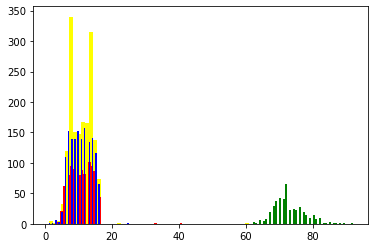

In [24]:
# arqueros
df_0 = df_skills[ df_skills['cluster']==0]
df_1 = df_skills[ df_skills['cluster']==1]
df_2 = df_skills[ df_skills['cluster']==2]
df_3 = df_skills[ df_skills['cluster']==3]

plt.hist(df_0['goalkeeping_handling'], color='yellow', bins=50)
plt.hist(df_1['goalkeeping_handling'], color='green', bins=50)
plt.hist(df_2['goalkeeping_handling'], color='red', bins=50)
plt.hist(df_3['goalkeeping_handling'], color='blue', bins=50)
plt.show()

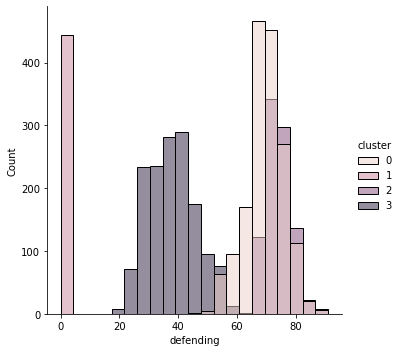

In [25]:
sns.displot(df_skills,x="defending",hue="cluster")

In [26]:
def distribution_per_type(df, col_name="", bins=20):
    plt.title(f"{col_name.capitalize()} Distribution")
    sns.distplot(df[df["cluster"] == 0][col_name],label="cluster-0", bins=bins)
    sns.distplot(df[df["cluster"] == 1][col_name],label="cluster-1", bins=bins)
    sns.distplot(df[df["cluster"] == 2][col_name],label="cluster-2", bins=bins)
    sns.distplot(df[df["cluster"] == 3][col_name],label="cluster-3", bins=bins)
    plt.legend()

In [27]:
def exploratory_plots(df, col_name=""):
    plt.subplot(3, 1, 1)
    distribution_per_type(df, col_name)
    plt.subplot(3, 1, 2)
    plt.title(f"{col_name.capitalize()} Boxplot")
    sns.boxplot(x="cluster", y=col_name, data=df)
    sns.set(rc={'figure.figsize':(20,15)})
    
    #plt.tight_layout()

In [28]:
df_skills["defending"].describe()

count    4512.000000
mean       53.068484
std        24.097258
min         0.000000
25%        36.000000
50%        64.000000
75%        72.000000
max        91.000000
Name: defending, dtype: float64

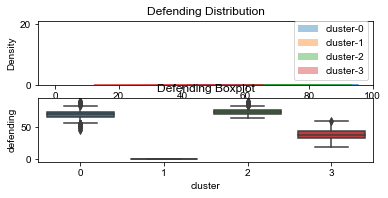

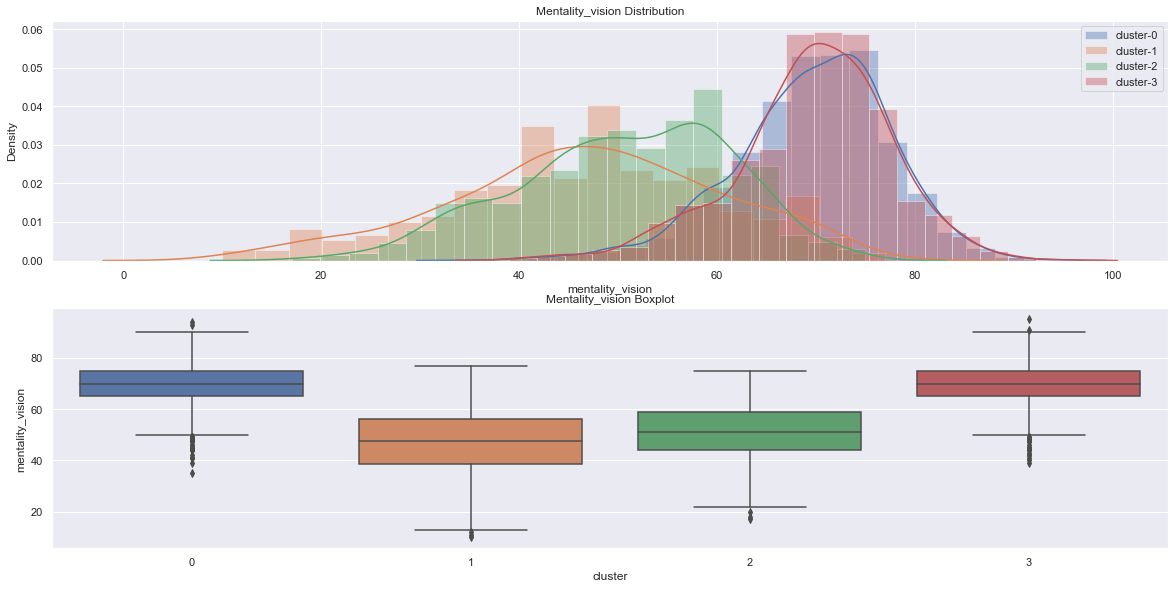

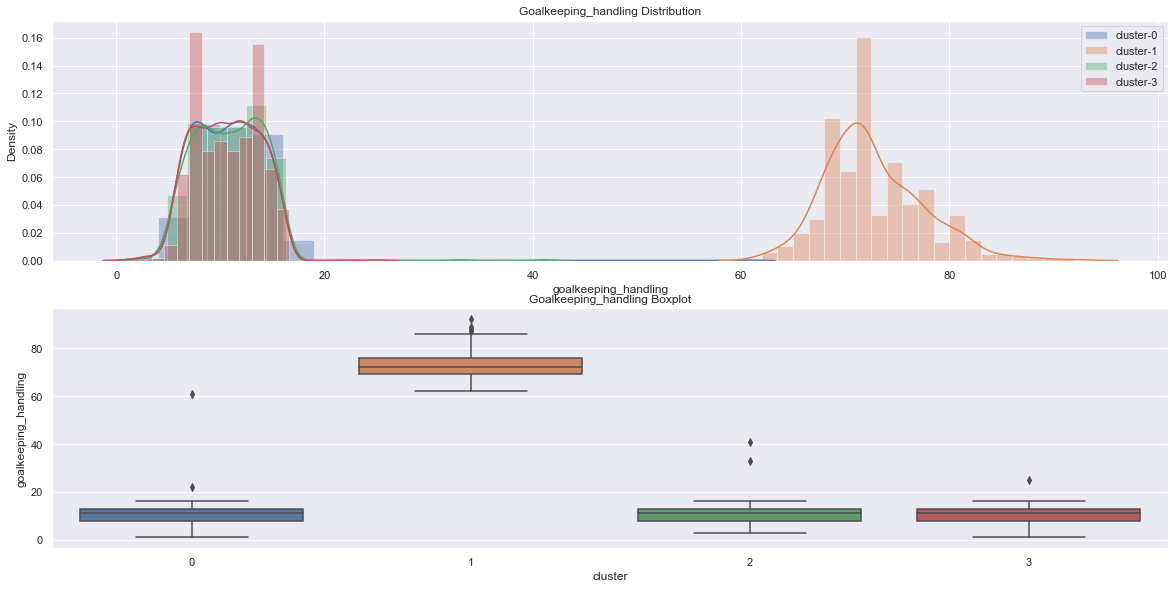

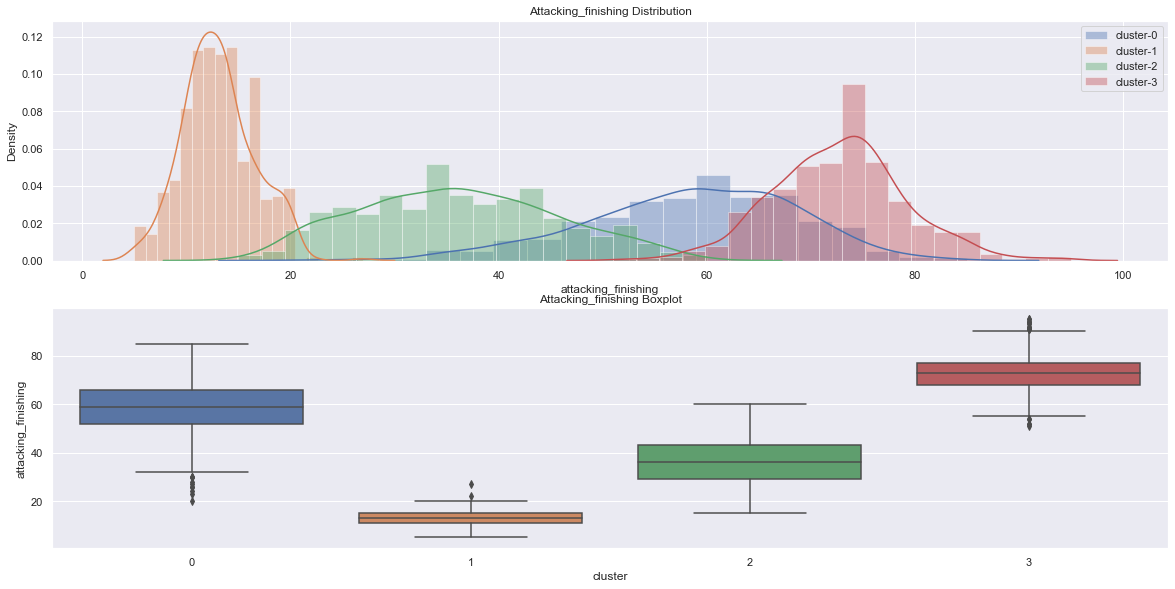

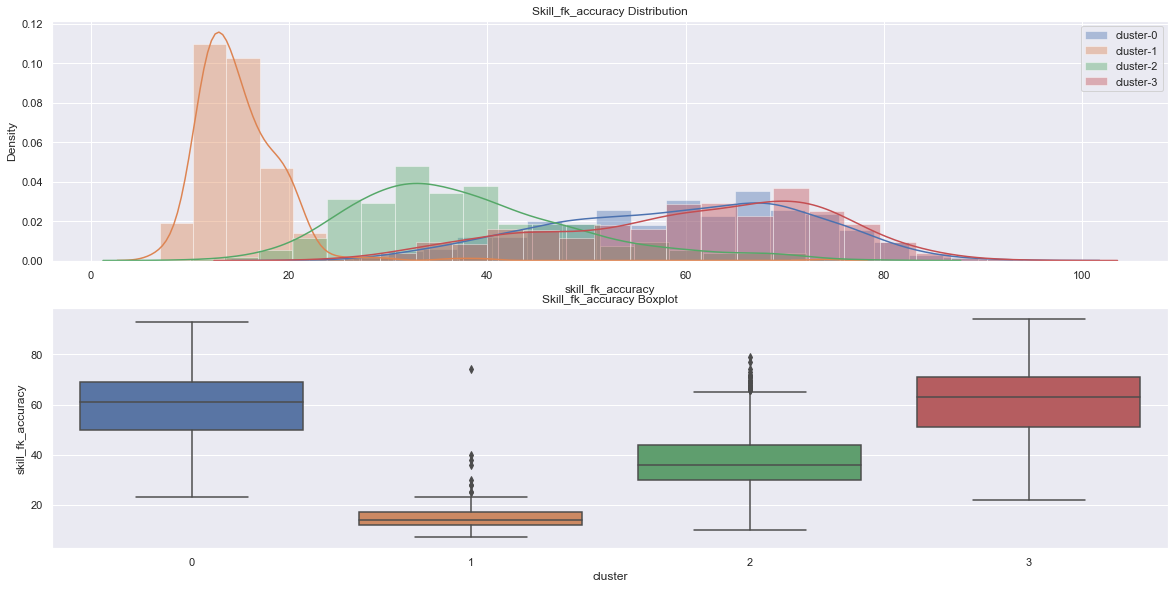

In [29]:
for skill in ["defending","mentality_vision","goalkeeping_handling","attacking_finishing", "skill_fk_accuracy"]:
    plt.figure()
    exploratory_plots(df_skills, skill)

# silhouette score

In [30]:
from sklearn.metrics import silhouette_score

In [31]:
score = silhouette_score(df_skills, km.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.325


In [32]:
!pip install yellowbrick

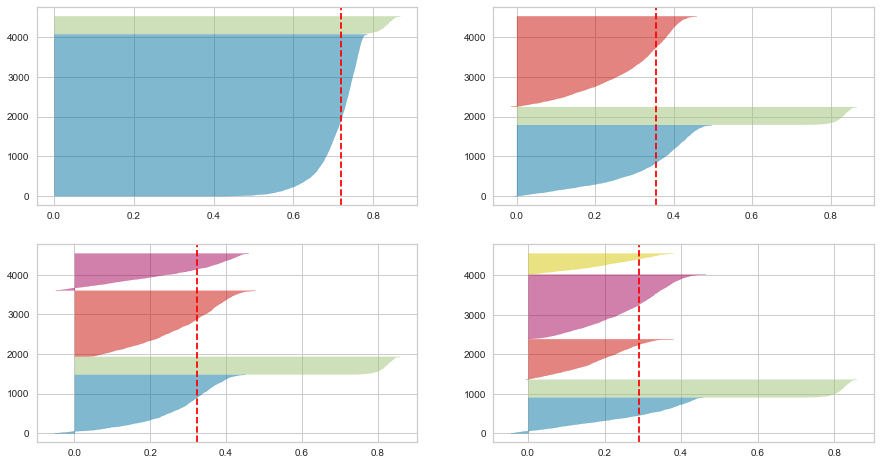

In [33]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_skills)

Podemos ver en estos graficos de silueta que cuando usamos 3 clusters es cuando mejora la media de los scores y se reduce la cantidad de picos negativos en comparacion a lo visible utilizando un K mayor. Se observa que las clusters estan "balanceados" exceptuando el cluster de color verde, que podriamos decir (a modo de hipotesis) que corresponde a los arqueros.

Para el analisis posterior utilizaremos  4 clusters, resultado obtenido siguiendo el metodo del codo.

In [35]:
df.describe(include=[object])

player_url    short_name  \
count                                               18944         18944   
unique                                              18944         17884   
top     https://sofifa.com/player/227790/seung-hyun-je...  J. Rodríguez   
freq                                                    1            13   

         long_name         dob nationality club_name  \
count        18944       18944       18944     18719   
unique       18896        6236         162       681   
top     Liam Kelly  1992-02-29     England   Arsenal   
freq             3         128        1685        33   

                        league_name player_positions preferred_foot  \
count                         18719            18944          18944   
unique                           52              611              2   
top     English League Championship               CB          Right   
freq                            709             2437          14448   

            work_rate body_type real_face player_tags team_position  \
count           18944     18944     18944        1408         18719   
unique              9       118         2          75            29   
top     Medium/Medium    Normal        No   #Strength           SUB   
freq             9980     11264     16746         459          8065   

       loaned_from      joined nation_position        player_traits     ls  \
count          758       17961            1127                 8315  18944   
unique         278        1822              26                  915    206   
top        Chelsea  2019-07-01             SUB  Speed Dribbler (AI)   61+2   
freq            12        1315             588                  627    708   

           st     rs     lw     lf     cf     rf     rw    lam    cam    ram  \
count   18944  18944  18944  18944  18944  18944  18944  18944  18944  18944   
unique    206    206    104    103    103    103    104    233    233    233   
top      61+2   61+2   64+0   62+0   62+0   62+0   64+0   62+2   62+2   62+2   
freq      708    708    749    771    771    771    749    713    713    713   

           lm    lcm     cm    rcm     rm    lwb    ldm    cdm    rdm    rwb  \
count   18944  18944  18944  18944  18944  18944  18944  18944  18944  18944   
unique    223    213    213    213    223    201    219    219    219    201   
top      61+2   61+2   61+2   61+2   61+2   59+2   61+2   61+2   61+2   59+2   
freq      745    776    776    776    745    717    614    614    614    717   

           lb    lcb     cb    rcb     rb  
count   18944  18944  18944  18944  18944  
unique    196    222    222    222    196  
top      60+2   61+2   61+2   61+2   60+2  
freq      680    528    528    528    680

# tabla de contingencia

In [36]:
pd.crosstab(df['work_rate'], df_skills['cluster']) 

cluster          0    1    2    3
work_rate                        
High/High      290    0   32  145
High/Low        26    0    1  200
High/Medium    524    0   96  540
Low/High        22    0   87    0
Low/Low          1    0    1    3
Low/Medium      10    0   66    2
Medium/High    251    0  289   26
Medium/Low      11    0    0  187
Medium/Medium  525  444  358  375

In [37]:
pd.crosstab(df['team_position'], df_skills['cluster']) 

cluster          0    1    2    3
team_position                    
CAM             41    0    0   87
CB              10    0   31    0
CDM             57    0   14    1
CF               2    0    0    6
CM              18    0    0    1
GK               0  293    0    0
LAM              2    0    0   10
LB             153    0   31    0
LCB             23    0  190    0
LCM            125    0    6   22
LDM             82    0   14    1
LF               2    0    0    6
LM              37    0    1  113
LS               1    0    0   84
LW               5    0    0   65
LWB             13    0    1    1
RAM              0    0    0   11
RB             154    0   59    1
RCB             28    0  191    0
RCM            124    0    5   11
RDM             72    0   23    2
RES             69   21   58   93
RF               2    0    0    5
RM              42    0    3  110
RS               4    0    0   74
RW               5    0    0   66
RWB             13    0    4    2
ST               1    0    0  173
SUB            544  119  279  506

Se utilizan 2 variables del dataset para hacer las tablas de contingencia buscando visualizar la division de los 4 clusters encontrados.

# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio/bandwith (de cobertura para cálculo de media). (Probar con varios)

In [84]:
df_skills_copy_ms = df_skills.drop(["cluster"], axis=1)
df_skills_copy_ms

pace  shooting  passing  dribbling  defending  physic  gk_diving  \
0     85.0      92.0     91.0       95.0       38.0    65.0        0.0   
1     89.0      93.0     81.0       89.0       35.0    77.0        0.0   
2      0.0       0.0      0.0        0.0        0.0     0.0       87.0   
3     78.0      91.0     78.0       85.0       43.0    82.0        0.0   
4     91.0      85.0     86.0       94.0       36.0    59.0        0.0   
...    ...       ...      ...        ...        ...     ...        ...   
4507  86.0      54.0     69.0       71.0       57.0    52.0        0.0   
4508  82.0      68.0     64.0       73.0       32.0    58.0        0.0   
4509  76.0      61.0     71.0       75.0       62.0    83.0        0.0   
4510   0.0       0.0      0.0        0.0        0.0     0.0       71.0   
4511  67.0      68.0     70.0       73.0       61.0    75.0        0.0   

      gk_handling  gk_kicking  gk_reflexes  gk_speed  gk_positioning  \
0             0.0         0.0          0.0       0.0             0.0   
1             0.0         0.0          0.0       0.0             0.0   
2            92.0        78.0         90.0      52.0            90.0   
3             0.0         0.0          0.0       0.0             0.0   
4             0.0         0.0          0.0       0.0             0.0   
...           ...         ...          ...       ...             ...   
4507          0.0         0.0          0.0       0.0             0.0   
4508          0.0         0.0          0.0       0.0             0.0   
4509          0.0         0.0          0.0       0.0             0.0   
4510         72.0        71.0         67.0      21.0            71.0   
4511          0.0         0.0          0.0       0.0             0.0   

      attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                     85                   95                          70   
1                     84                   95                          90   
2                     13                   11                          15   
3                     71                   94                          85   
4                     85                   87                          62   
...                  ...                  ...                         ...   
4507                  76                   54                          54   
4508                  68                   68                          48   
4509                  67                   55                          51   
4510                  14                    6                          13   
4511                  59                   70                          50   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                          91                 88               96   
1                          82                 86               88   
2                          43                 13               12   
3                          84                 89               85   
4                          87                 87               95   
...                       ...                ...              ...   
4507                       67                 55               70   
4508                       69                 61               73   
4509                       73                 51               73   
4510                       21                  9                9   
4511                       75                 61               73   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0              93                 94                  91                  96   
1              81                 76                  77                  92   
2              13                 14                  40                  30   
3              79                 85                  70                  88   
4              88                 89                  81                  95   
...           ... 

In [85]:
ms = MeanShift(bandwidth=100)

ms.fit(df_skills_copy_ms)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 2


In [78]:
def search_ms_optimus(data_clus, bandwidth):
    sse ={}
    for bw in bandwidth:
        clusterer = MeanShift(bandwidth=bw)
        print("Start fitting")
        cluster_labels = clusterer.fit_predict(data_clus)
        print("Stop fitting")
        #sse[n_clusters] = clusterer.inertia_

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data_clus, cluster_labels, random_state=352)
        print("Para bamdwith =", bw,
              "El silhouette_score promedio es :", silhouette_avg)
        print (" Para bandwidth =", bw, "La cantidad de clusters encontrados es: ", len(np.unique(clusterer.labels_)))

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data_clus, cluster_labels)

        plot_silouette(sample_silhouette_values, cluster_labels,
                       silhouette_avg, title="bw={}".format(bw))
    return sse

In [79]:
def plot_silouette(silhouette_values, cluster_labels, silhouette_avg, 
                   title="Visualizacion de los datos"):
    fig, ax1 = plt.subplots(1, 1)
    y_lower = 10
    n_clusters = len(np.unique(cluster_labels))
    for i in np.unique(cluster_labels):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color   = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(title)
    # ax1.set_xlabel("espacio de la primera caracteristica")
    # ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

Start fitting
Stop fitting
Para bamdwith = 67 El silhouette_score promedio es : 0.23645438712802333
 Para bandwidth = 67 La cantidad de clusters encontrados es:  6


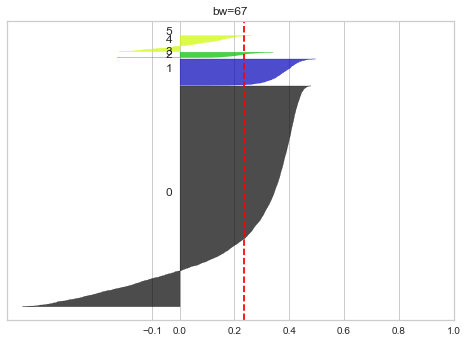

Start fitting
Stop fitting
Para bamdwith = 80 El silhouette_score promedio es : 0.33995158892619054
 Para bandwidth = 80 La cantidad de clusters encontrados es:  3


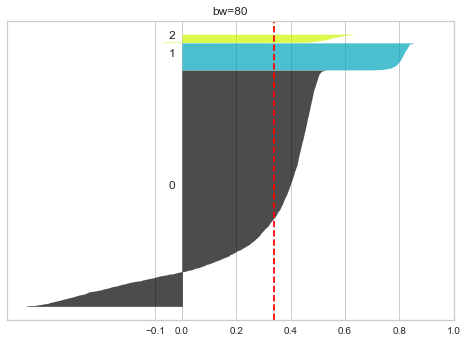

Start fitting
Stop fitting
Para bamdwith = 100 El silhouette_score promedio es : 0.7192660377889606
 Para bandwidth = 100 La cantidad de clusters encontrados es:  2


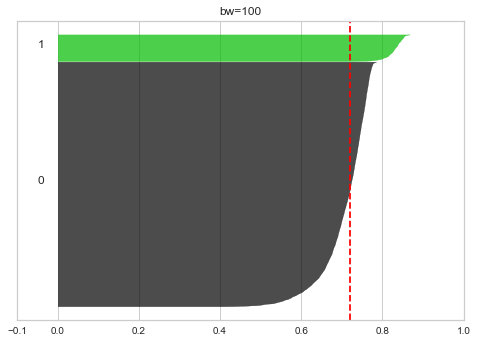

{}

In [86]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
bandwidth = [67,80, 100]
search_ms_optimus(df_skills_copy_ms,bandwidth)

Al igual que con KMeans, el mayor score de silueta se encuentra con 2 clusters. Se puede observar que los clusters estan desbalanceados. Nuestra hipotesis, al igual que en el caso anterior, es que nuestros modelos estan aprendiendo solo a separar a los arqueros de los demas jugadores.

In [87]:
ms = MeanShift(bandwidth=100)

ms.fit(df_skills_copy_ms)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 2


In [88]:
df_skills_copy_ms['cluster'] = clusters2

In [89]:
df_skills_copy_ms.head()

pace  shooting  passing  dribbling  defending  physic  gk_diving  \
0  85.0      92.0     91.0       95.0       38.0    65.0        0.0   
1  89.0      93.0     81.0       89.0       35.0    77.0        0.0   
2   0.0       0.0      0.0        0.0        0.0     0.0       87.0   
3  78.0      91.0     78.0       85.0       43.0    82.0        0.0   
4  91.0      85.0     86.0       94.0       36.0    59.0        0.0   

   gk_handling  gk_kicking  gk_reflexes  gk_speed  gk_positioning  \
0          0.0         0.0          0.0       0.0             0.0   
1          0.0         0.0          0.0       0.0             0.0   
2         92.0        78.0         90.0      52.0            90.0   
3          0.0         0.0          0.0       0.0             0.0   
4          0.0         0.0          0.0       0.0             0.0   

   attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                  85                   95                          70   
1                  84                   95                          90   
2                  13                   11                          15   
3                  71                   94                          85   
4                  85                   87                          62   

   attacking_short_passing  attacking_volleys  skill_dribbling  skill_curve  \
0                       91                 88               96           93   
1                       82                 86               88           81   
2                       43                 13               12           13   
3                       84                 89               85           79   
4                       87                 87               95           88   

   skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0                 94                  91                  96   
1                 76                  77                  92   
2                 14                  40                  30   
3                 85                  70                  88   
4                 89                  81                  95   

   movement_acceleration  movement_sprint_speed  movement_agility  \
0                     91                     80                91   
1                     87                     91                87   
2                     43                     60                67   
3                     77                     78                77   
4                     94                     89                96   

   movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                  94                95                86             68   
1                  95                71                94             95   
2                  88                49                59             78   
3                  93                82                89             84   
4                  91                83                80             62   

   power_stamina  power_strength  power_long_shots  mentality_aggression  \
0             72              69                94                    44   
1             84              78                93                    63   
2             41              78                12                    34   
3             76              86                85                    81   
4             81              50                84                    51   

   mentality_interceptions  mentality_positioning  mentality_vision  \
0                       40                     93                95   
1                       29                     95                82   
2                       19                     11                65   
3                       49                     94                79   
4                       36                     87                90   

   mentality_penalties  mentality_composure  defending_marking  \
0                   75            

Graficamos los resultados:

In [ ]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

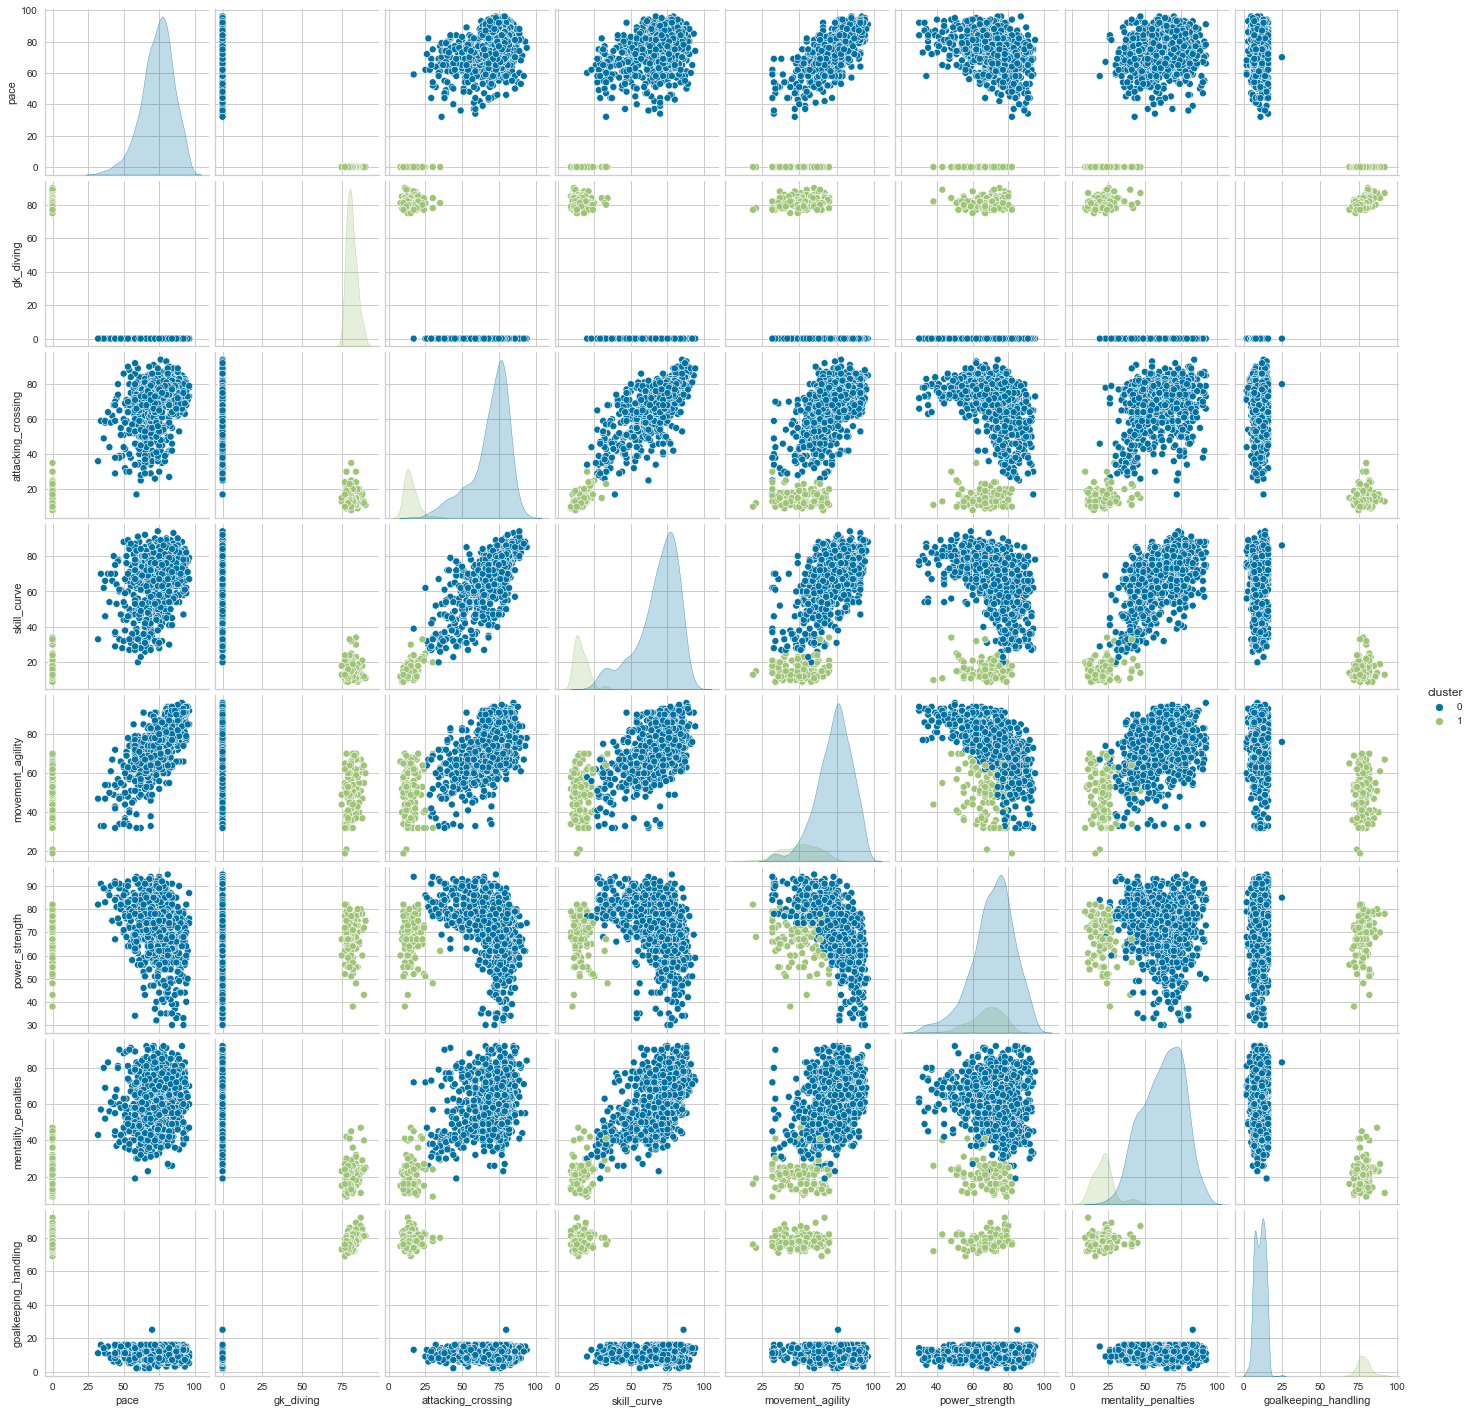

In [90]:
sns.pairplot(
    df_skills_copy_ms[:1000],
    x_vars=skills_ratings[0:46:6],
    y_vars=skills_ratings[0:46:6],
    hue="cluster"
)

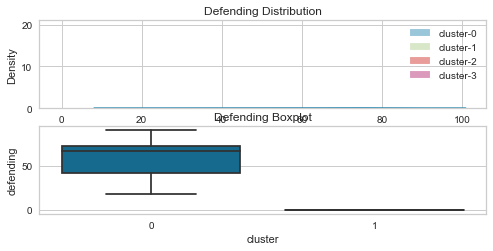

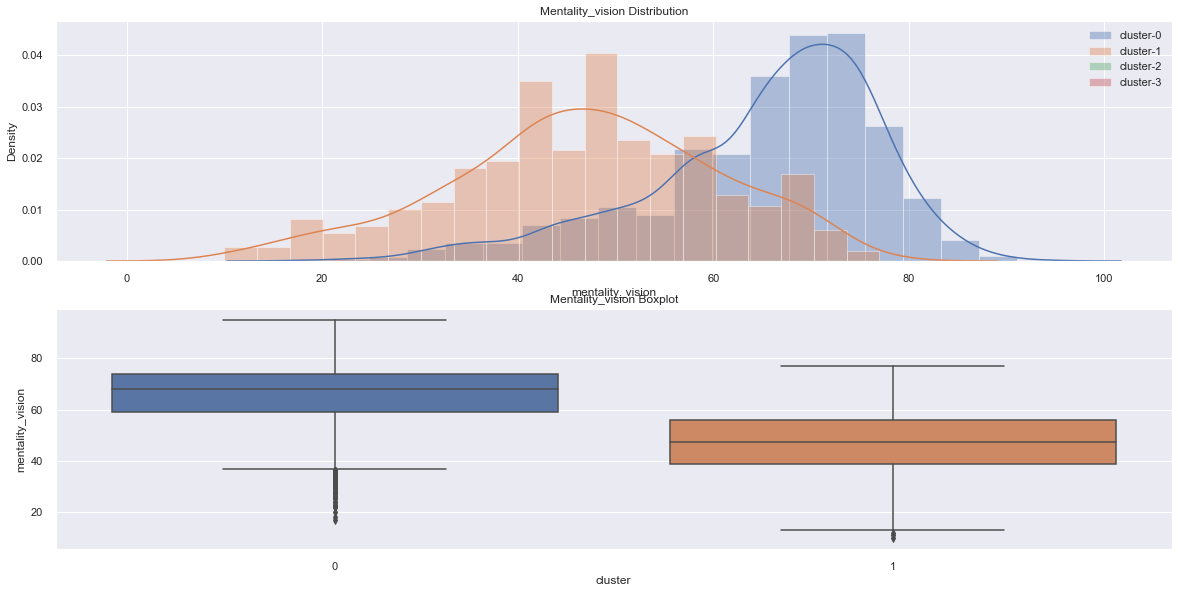

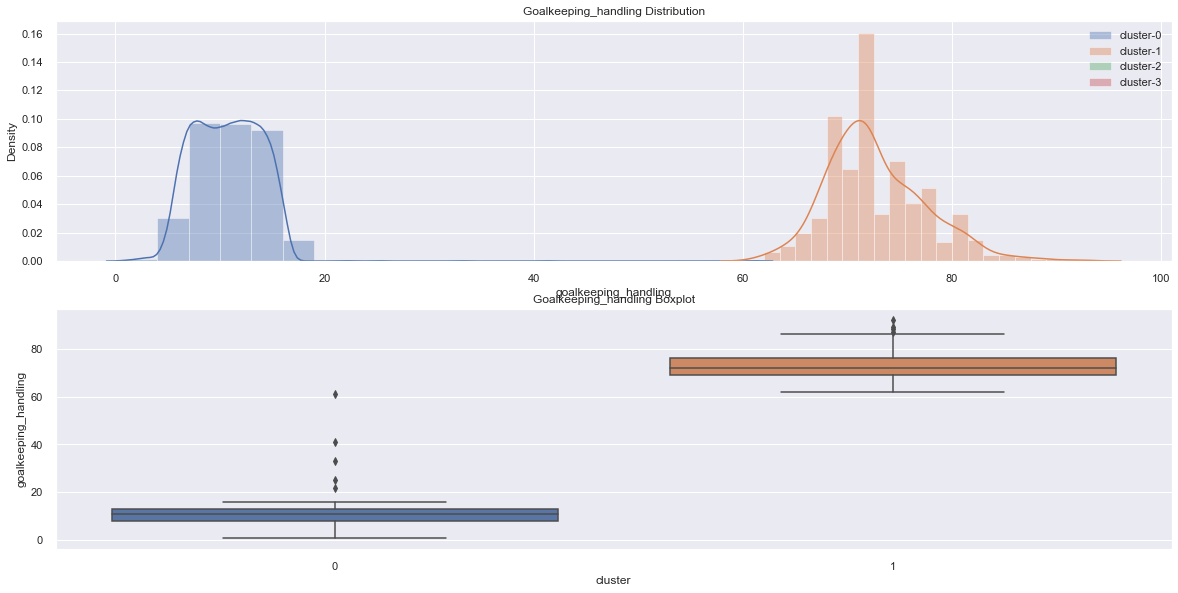

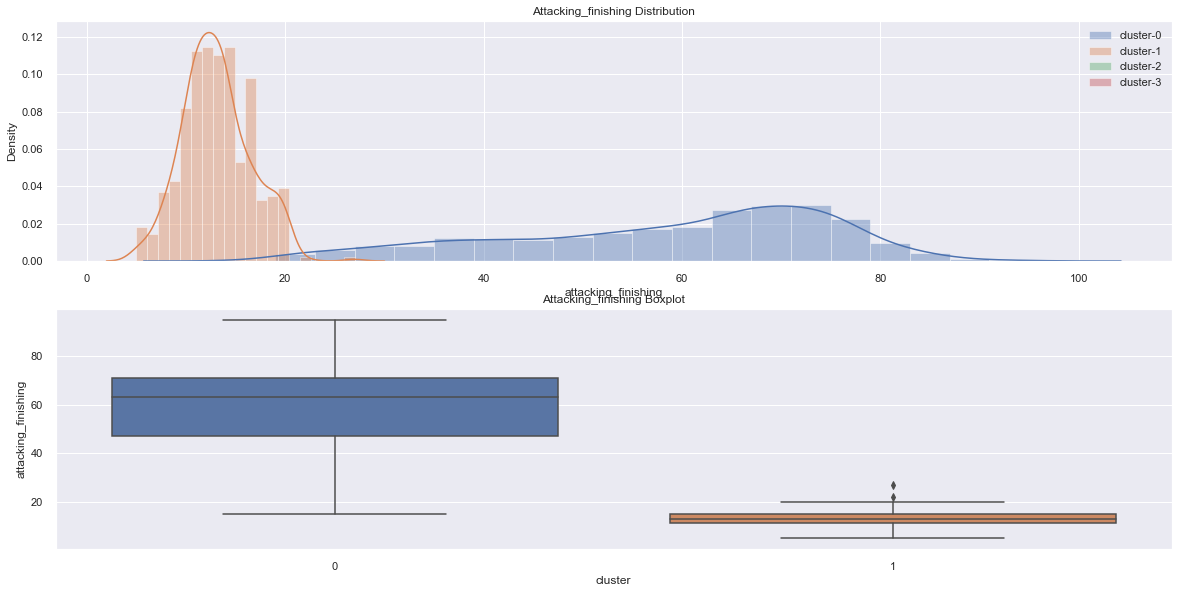

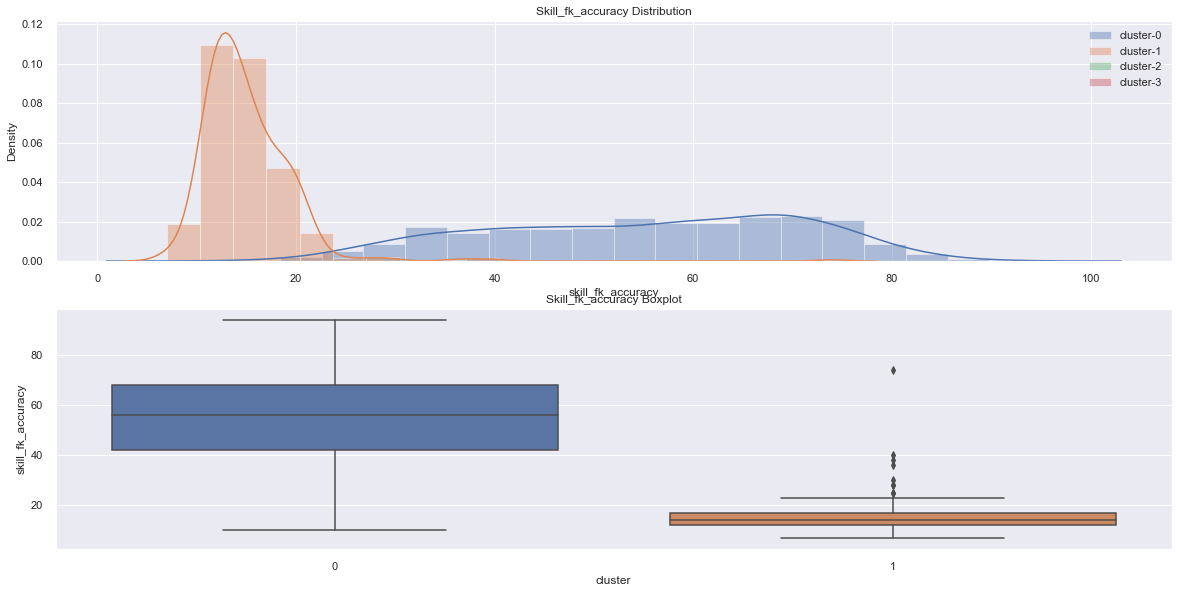

In [91]:
for skill in ["defending","mentality_vision","goalkeeping_handling","attacking_finishing", "skill_fk_accuracy"]:
    plt.figure()
    exploratory_plots(df_skills_copy_ms, skill)

In [92]:
pd.crosstab(df['work_rate'], df_skills_copy_ms['cluster']) 

cluster           0    1
work_rate               
High/High       467    0
High/Low        227    0
High/Medium    1160    0
Low/High        109    0
Low/Low           5    0
Low/Medium       78    0
Medium/High     566    0
Medium/Low      198    0
Medium/Medium  1258  444

In [94]:
pd.crosstab(df['team_position'], df_skills_copy_ms['cluster']) 

cluster           0    1
team_position           
CAM             128    0
CB               41    0
CDM              72    0
CF                8    0
CM               19    0
GK                0  293
LAM              12    0
LB              184    0
LCB             213    0
LCM             153    0
LDM              97    0
LF                8    0
LM              151    0
LS               85    0
LW               70    0
LWB              15    0
RAM              11    0
RB              214    0
RCB             219    0
RCM             140    0
RDM              97    0
RES             220   21
RF                7    0
RM              155    0
RS               78    0
RW               71    0
RWB              19    0
ST              174    0
SUB            1329  119

In [95]:
### Cantidad de muestras por cluster
df_skills_copy_ms["cluster"].value_counts()

0    4068
1     444
Name: cluster, dtype: int64

In [97]:
### Cantidad de muestras en clusters hechos por nosotros
df_skill_copy["position"].value_counts()

delanteros       1972
defensores       1412
mediocampista     746
arquero           382
Name: position, dtype: int64

En esta comparacion, vemos como MeanShift separa a los arqueros del resto de los jugadores

**Pregunta: normalizamos/estandarizamos la base?**

Creemos que no es necesario normalizar/estandarizar debido a que todas las skills toman valores entre en rango 1-100. En el caso de que no fuese asi, si se deberia normalizar

In [99]:
df_skills_copy_ms.describe()

pace     shooting      passing    dribbling    defending  \
count  4512.000000  4512.000000  4512.000000  4512.000000  4512.000000   
mean     63.617021    55.442819    60.285683    64.043883    53.068484   
std      23.936609    22.286069    21.377173    22.625101    24.097258   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      60.000000    47.000000    59.000000    64.000000    36.000000   
50%      70.000000    63.000000    67.000000    71.000000    64.000000   
75%      78.000000    71.000000    72.000000    76.000000    72.000000   
max      96.000000    93.000000    93.000000    95.000000    91.000000   

            physic   gk_diving  gk_handling   gk_kicking  gk_reflexes  \
count  4512.000000  4512.00000  4512.000000  4512.000000  4512.000000   
mean     63.414672     7.43883     7.150488     6.925089     7.583112   
std      22.360616    22.56320    21.695954    21.050470    23.002274   
min       0.000000     0.00000     0.000000     0.000000     0.000000   
25%      63.000000     0.00000     0.000000     0.000000     0.000000   
50%      70.000000     0.00000     0.000000     0.000000     0.000000   
75%      76.000000     0.00000     0.000000     0.000000     0.000000   
max      91.000000    90.00000    92.000000    93.000000    90.000000   

          gk_speed  gk_positioning  attacking_crossing  attacking_finishing  \
count  4512.000000     4512.000000         4512.000000          4512.000000   
mean      4.373892        7.337766           59.079787            54.048094   
std      13.527809       22.258678           19.162140            20.569742   
min       0.000000        0.000000            6.000000             5.000000   
25%       0.000000        0.000000           51.000000            40.000000   
50%       0.000000        0.000000           66.000000            60.000000   
75%       0.000000        0.000000           72.000000            70.000000   
max      65.000000       91.000000           94.000000            95.000000   

       attacking_heading_accuracy  attacking_short_passing  attacking_volleys  \
count                 4512.000000              4512.000000        4512.000000   
mean                    58.781250                68.045434          51.478059   
std                     18.553099                13.957831          19.436485   
min                      7.000000                11.000000           4.000000   
25%                     51.000000                66.000000          38.000000   
50%                     63.000000                72.000000          56.000000   
75%                     72.000000                76.000000          67.000000   
max                     93.000000                94.000000          90.000000   

       skill_dribbling  skill_curve  skill_fk_accuracy  skill_long_passing  \
count      4512.000000  4512.000000        4512.000000         4512.000000   
mean         64.764849    57.547207          51.046099           62.381206   
std          19.066565    19.686863          19.291728           14.423760   
min           7.000000     6.000000           7.000000            9.000000   
25%          62.000000    47.000000          37.000000           58.000000   
50%          71.000000    63.000000          54.000000           66.000000   
75%          76.000000    72.000000          67.000000           72.000000   
max          96.000000    94.000000          94.000000           93.000000   

       skill_ball_control  movement_acceleration  movement_sprint_speed  \
count         4512.000000            4512.000000            4512.000000   
mean            67.876330              67.974512              67.992908   
std             16.417431              14.542411              14.305947   
min              5.000000              17.000000              15.000000   
25%             67.000000              60.000000              61.000000   
50%             73.000000              70.000000              70.000000   
75%             77.

**Ahora vemos que agrupamientos se pueden hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-sin-arqueros

In [164]:
n=10000
df_n=df.copy()
df_n=df_n[(df_n["team_position"]!='GK')]
df_n=df_n[df_n['overall']>70]


skills_ratings = ['pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

df_skills=df_n[skills_ratings]
df_skills.fillna(0,inplace=True)

In [165]:
df_n['team_position'].value_counts()

SUB    1448
RES     241
RCB     219
RB      214
LCB     213
LB      184
ST      174
RM      155
LCM     153
LM      151
RCM     140
CAM     128
RDM      97
LDM      97
LS       85
RS       78
CDM      72
RW       71
LW       70
CB       41
CM       19
RWB      19
LWB      15
LAM      12
RAM      11
CF        8
LF        8
RF        7
Name: team_position, dtype: int64

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

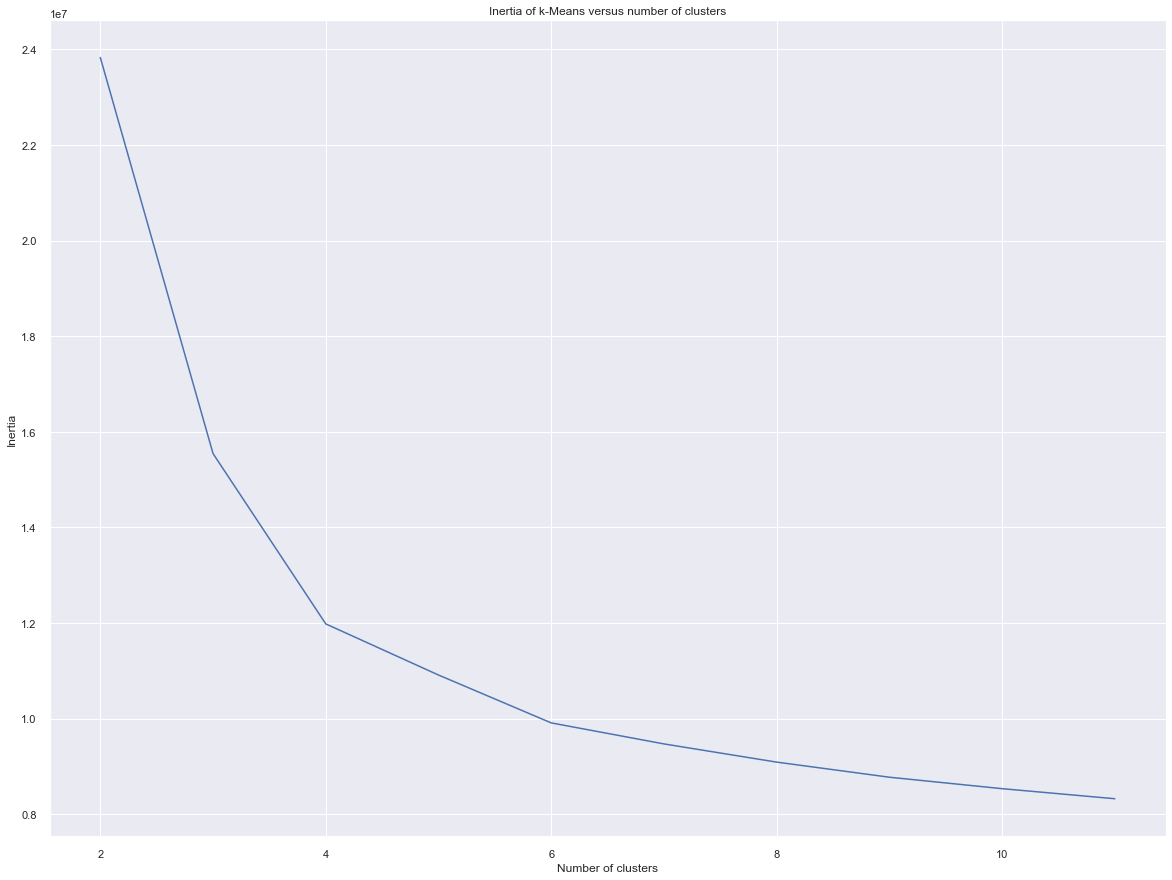

In [175]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

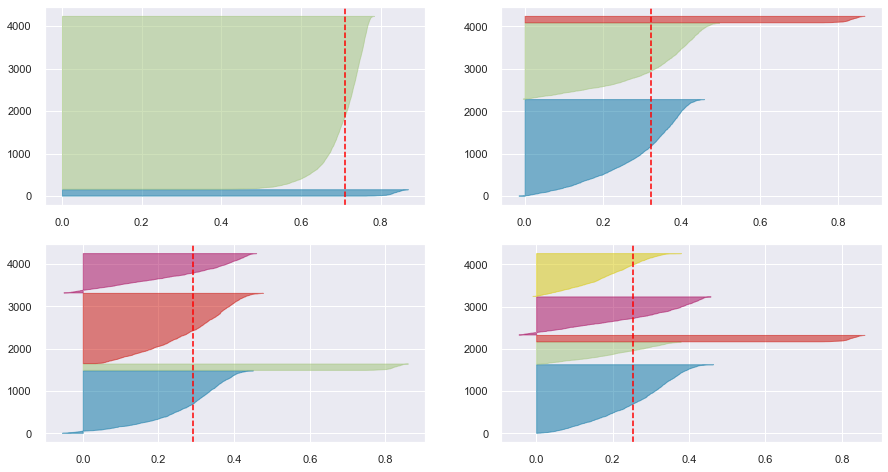

In [177]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_skills)

In [178]:
# Número de clusters buscado
n_clust = 3

km = KMeans(n_clusters=n_clust)
km.fit(df_skills) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  15545319.329703173


In [179]:
df_skills['cluster'] = clusters

In [180]:
df_skills['cluster'].value_counts()

2    2277
0    1791
1     151
Name: cluster, dtype: int64

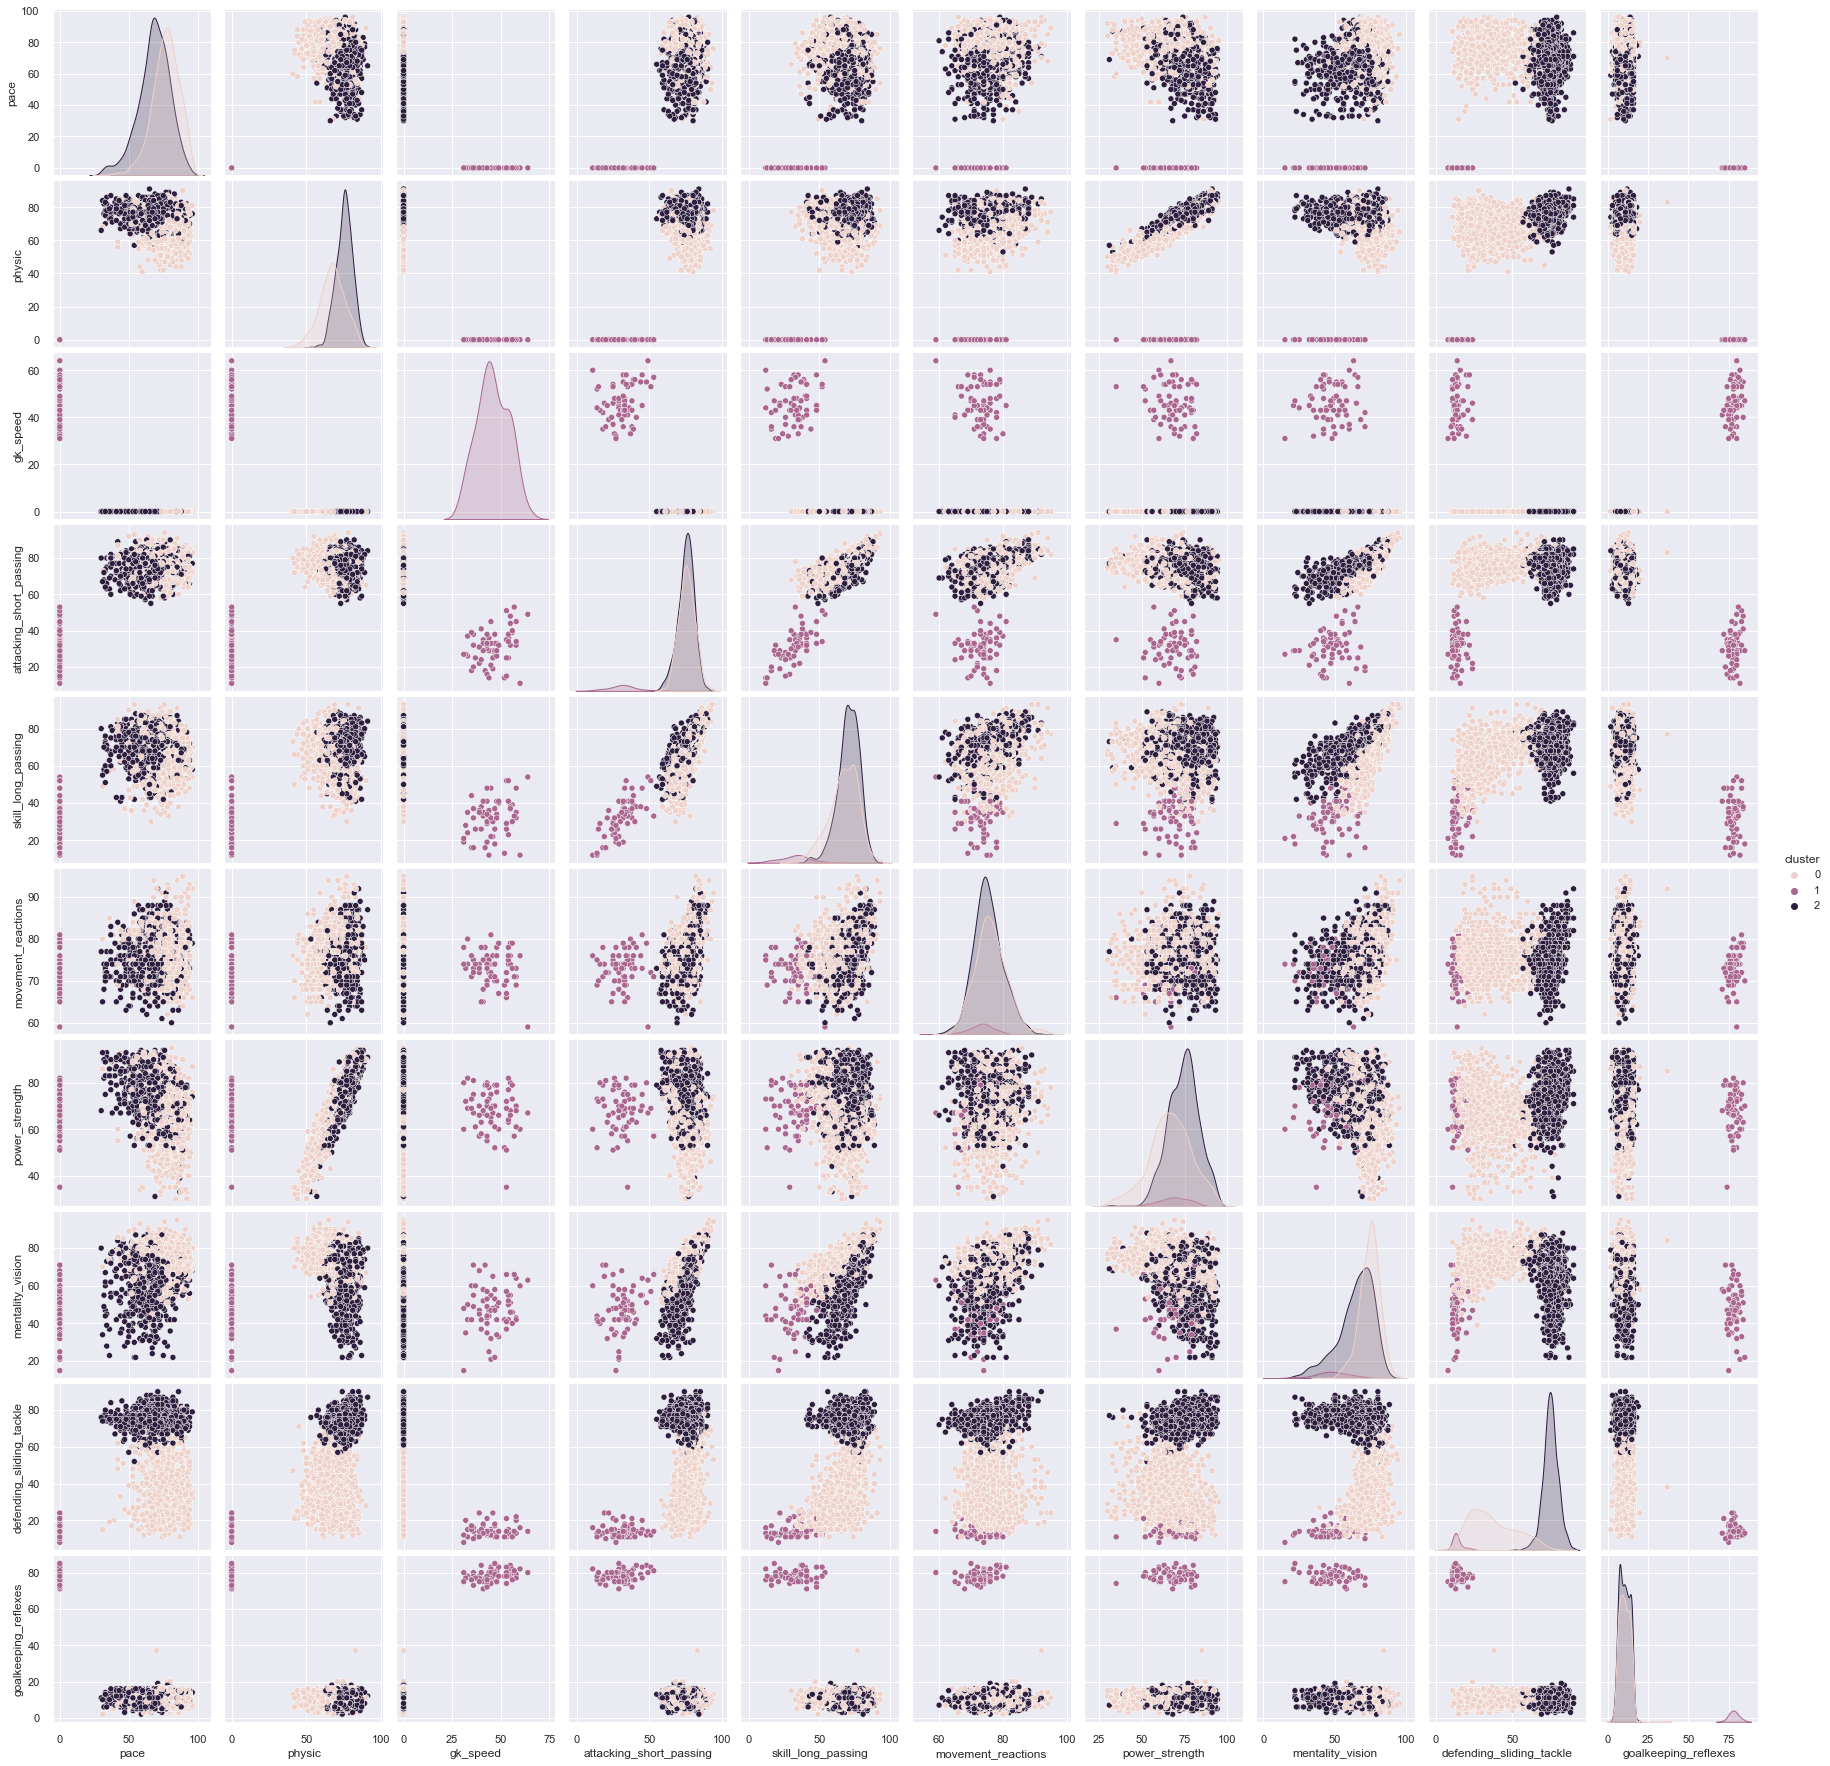

In [181]:
sns.pairplot(
    df_skills[:2000],
    x_vars=skills_ratings[0:46:5],
    y_vars=skills_ratings[0:46:5],
    hue="cluster"
)

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [182]:
df_skills_copy_ms = df_skills.drop(['cluster'],axis=1)

In [ ]:
ms = MeanShift(bandwidth= 80)

ms.fit(df_skills_copy_ms)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)

Start fitting
Stop fitting
Para bamdwith = 67 El silhouette_score promedio es : 0.2429306343810006
 Para bandwidth = 67 La cantidad de clusters encontrados es:  5


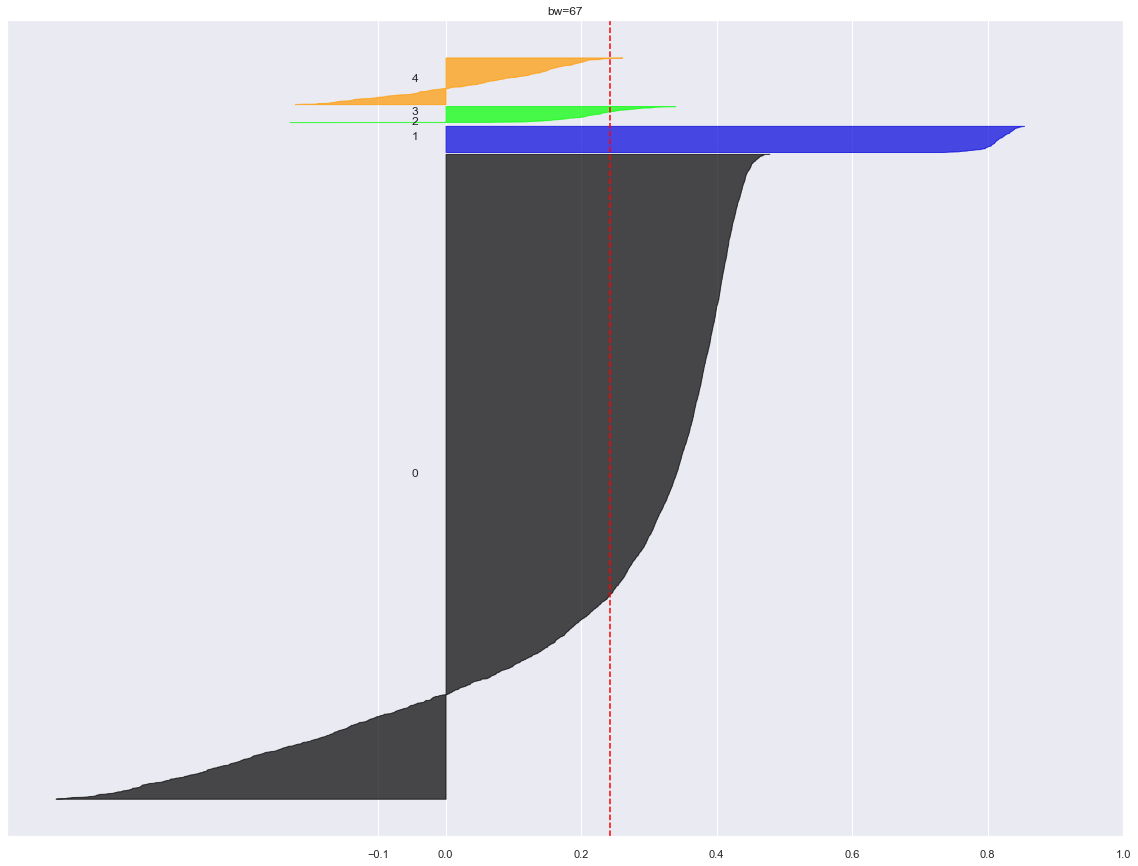

Start fitting
Stop fitting
Para bamdwith = 80 El silhouette_score promedio es : 0.30768612385181315
 Para bandwidth = 80 La cantidad de clusters encontrados es:  3


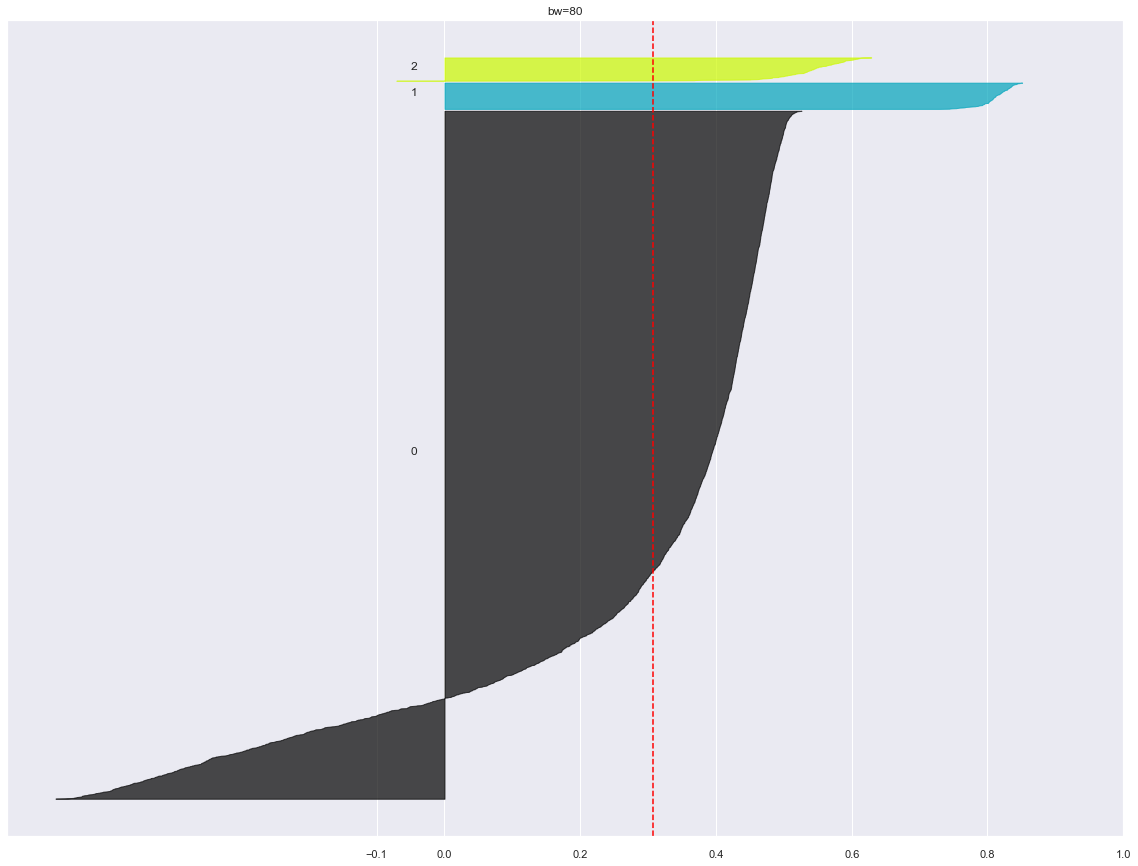

Start fitting
Stop fitting
Para bamdwith = 100 El silhouette_score promedio es : 0.7105585058781332
 Para bandwidth = 100 La cantidad de clusters encontrados es:  2


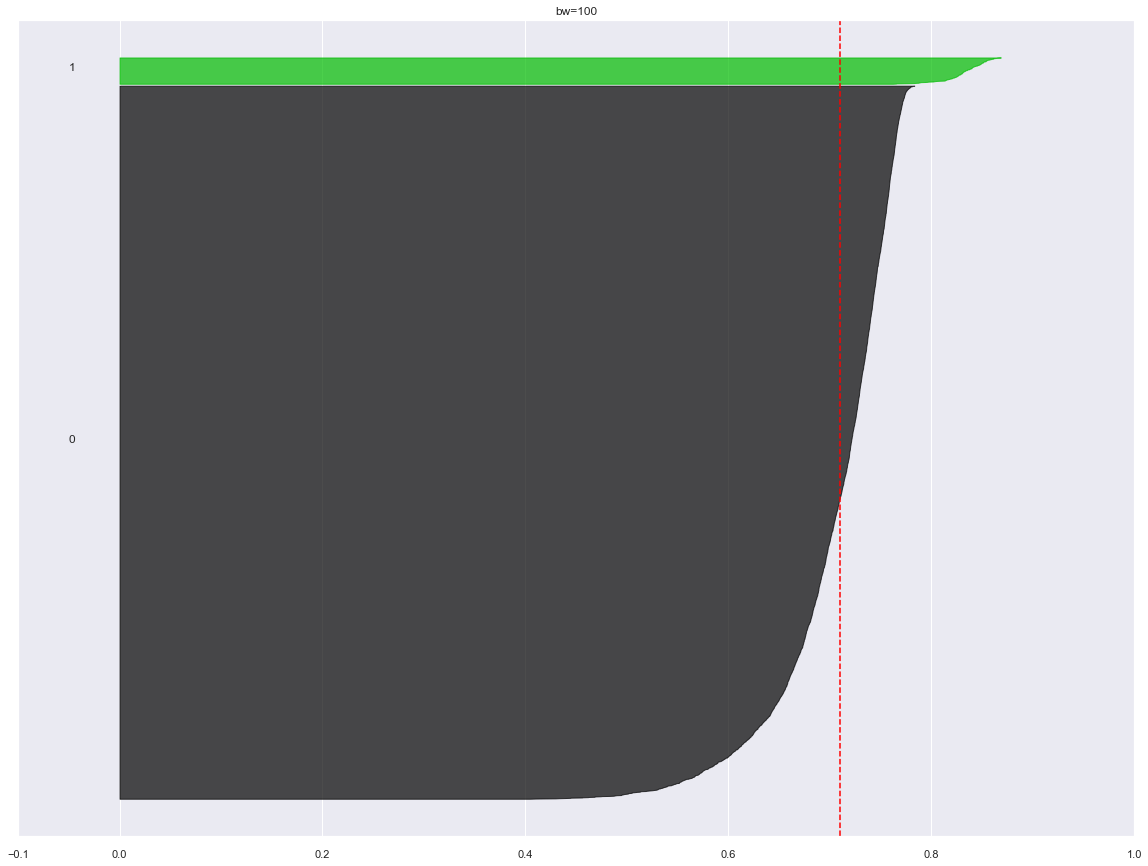

{}

In [184]:
bandwidth = [67, 80, 100]
search_ms_optimus(df_skills_copy_ms,bandwidth)

**Análisis exploratorio de las clases**

In [ ]:
df_skills_copy_ms['cluster'] = clusters2

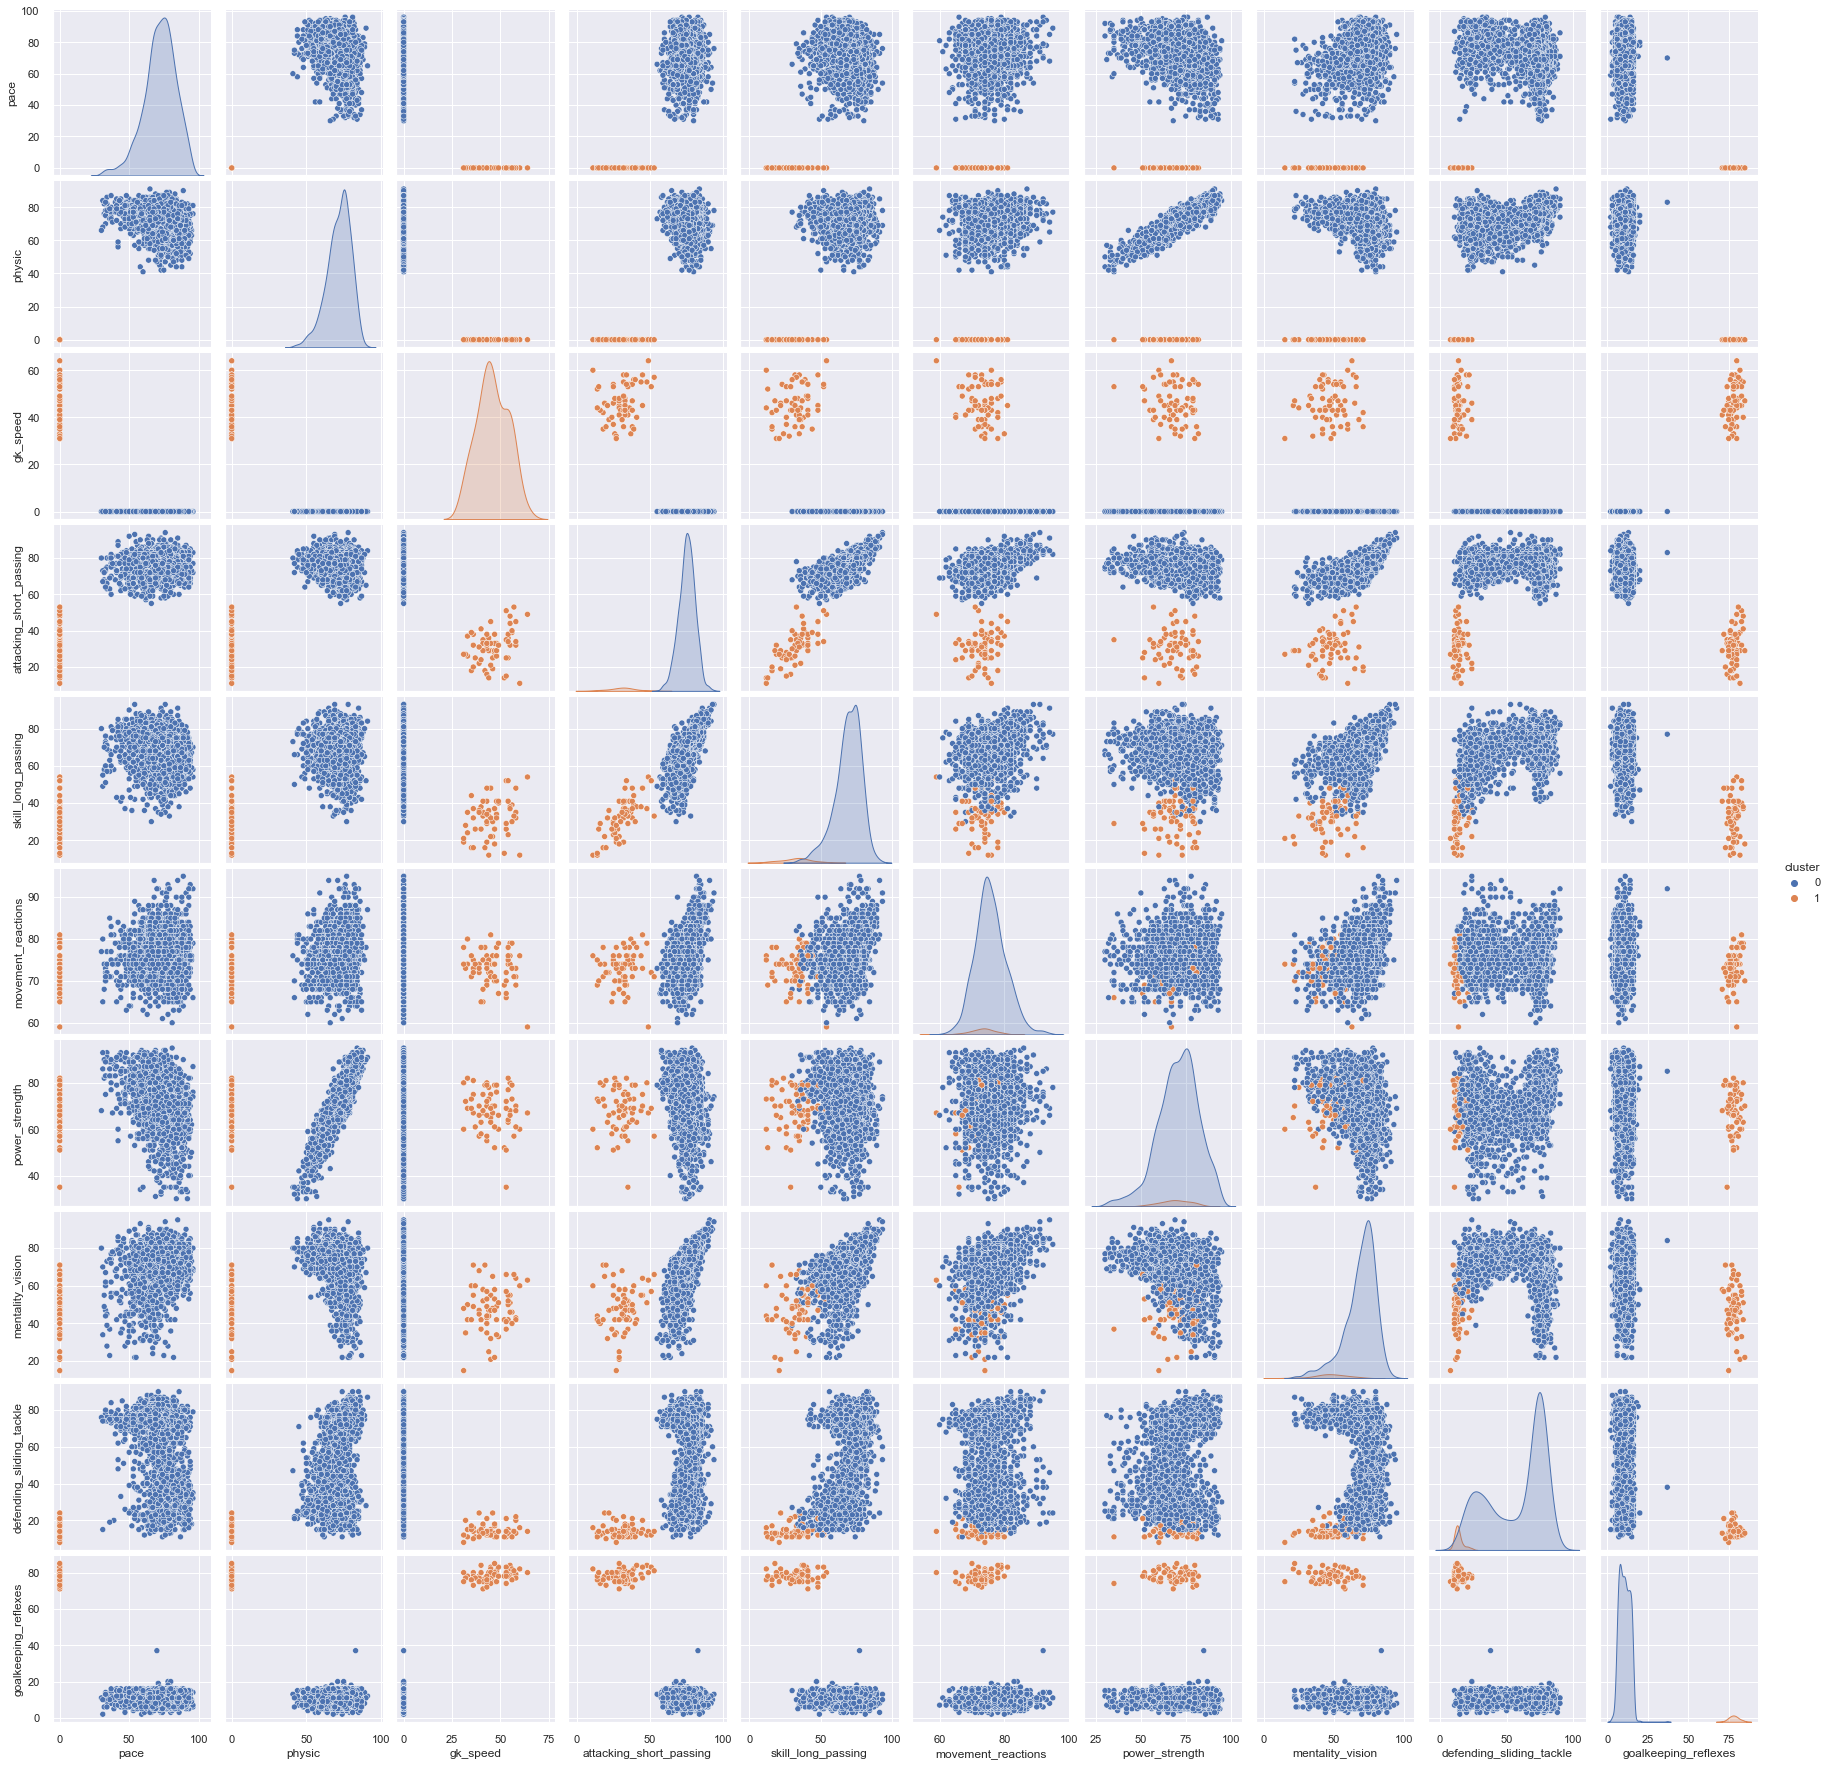

In [193]:
sns.pairplot(
    df_skills_copy_ms[:2000],
    x_vars=skills_ratings[0:46:5],
    y_vars=skills_ratings[0:46:5],
    hue="cluster"
)

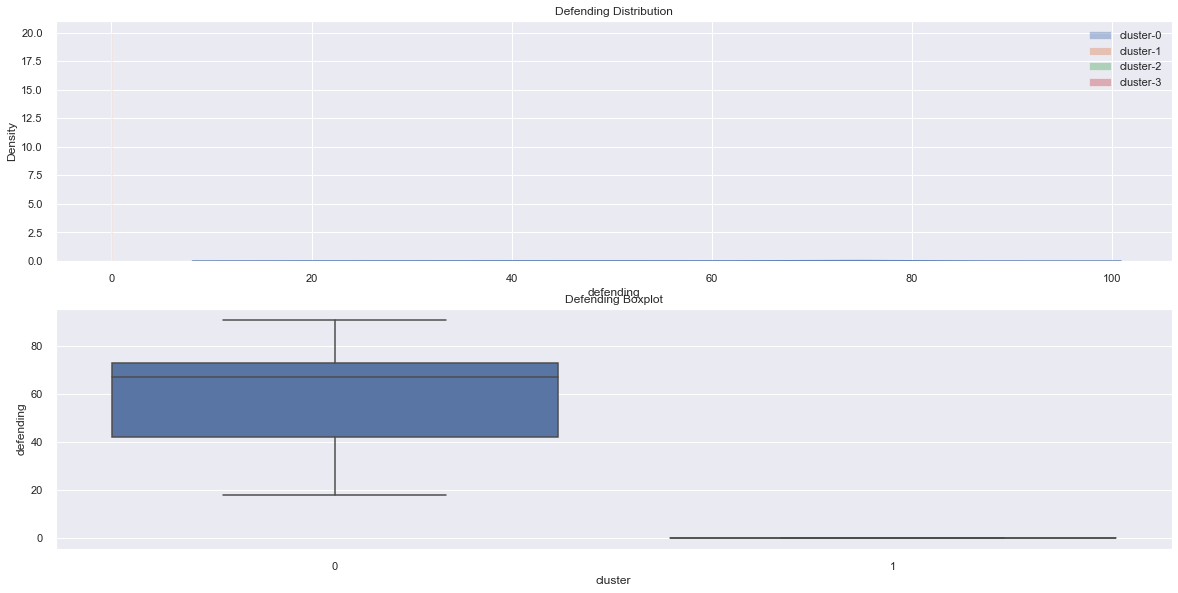

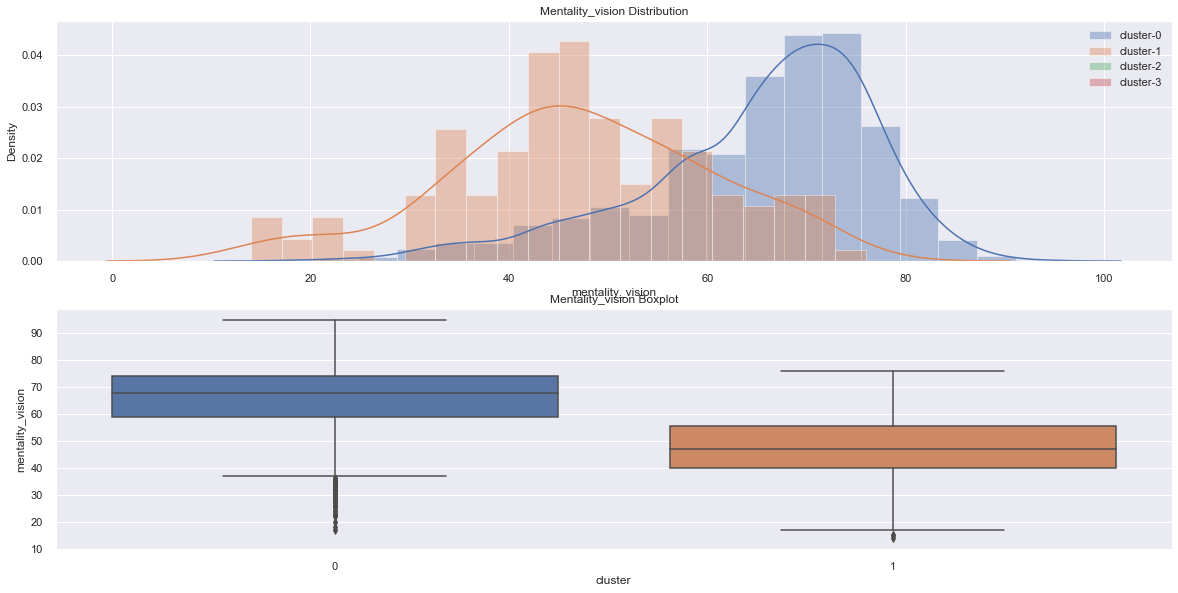

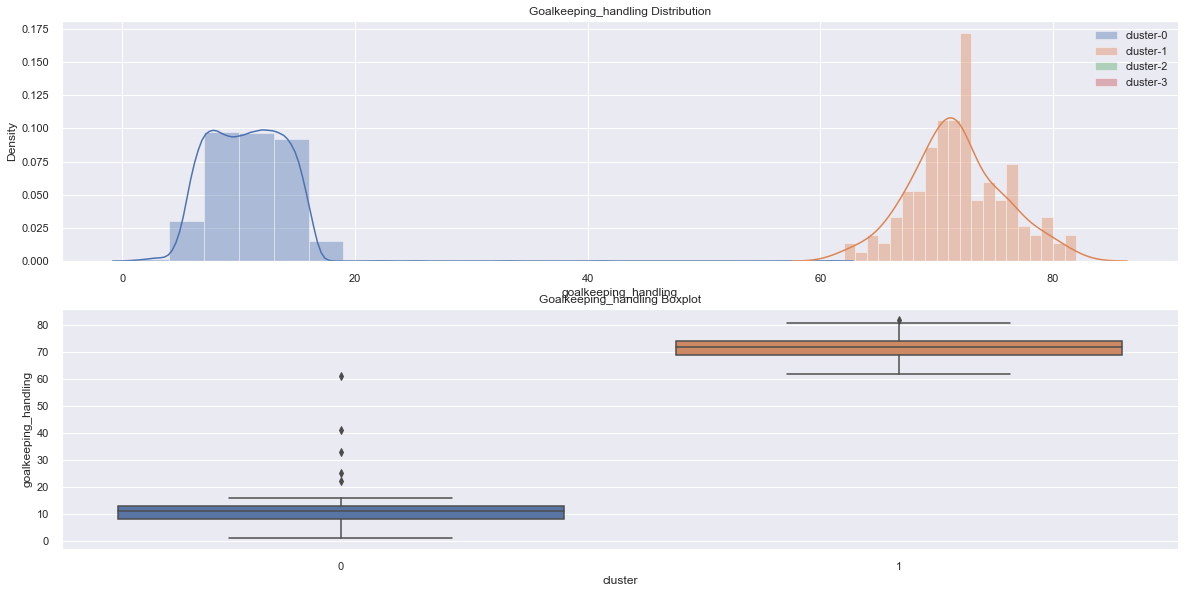

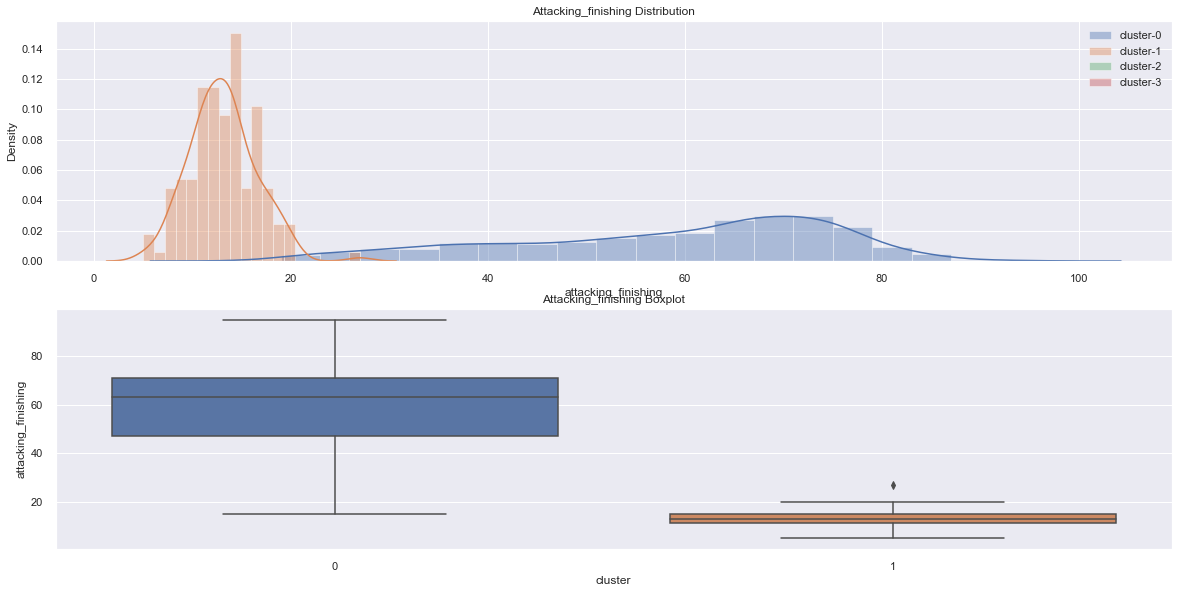

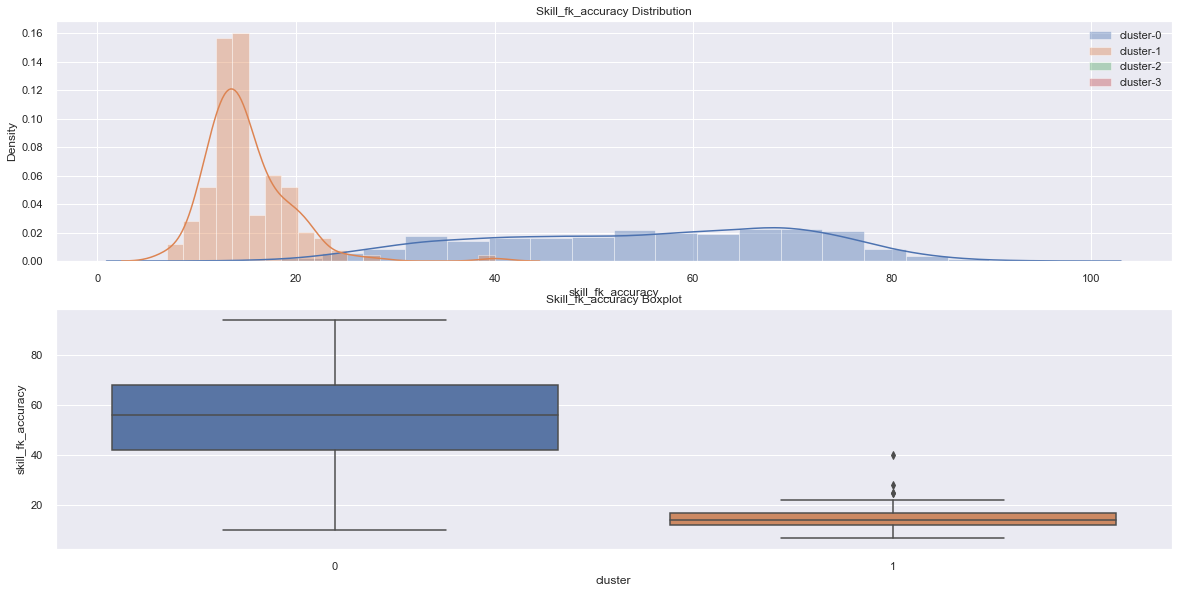

In [194]:
for skill in ["defending","mentality_vision","goalkeeping_handling","attacking_finishing", "skill_fk_accuracy"]:
    plt.figure()
    exploratory_plots(df_skills_copy_ms, skill)